In [1]:
import pandas as pd

df_items = pd.read_csv('australian_user_items.csv')
df_items.head()


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [2]:
import ast

# Asegurarse de que la columna items es una lista de diccionarios
df_items['items'] = df_items['items'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Explota la columna items para obtener una fila por juego
df_exploded = df_items.explode('items')

# Extrae item_id y item_name de cada diccionario
df_exploded['item_id'] = df_exploded['items'].apply(lambda d: d.get('item_id') if isinstance(d, dict) else None)
df_exploded['item_name'] = df_exploded['items'].apply(lambda d: d.get('item_name') if isinstance(d, dict) else None)

# Conservamos solo columnas necesarias
df_user_item = df_exploded[['user_id', 'item_id', 'item_name']].dropna()

df_user_item.head()


,user_id,item_id,item_name
0,76561197970982479,10,Counter-Strike
0,76561197970982479,20,Team Fortress Classic
0,76561197970982479,30,Day of Defeat
0,76561197970982479,40,Deathmatch Classic
0,76561197970982479,50,Half-Life: Opposing Force


In [3]:
# Ver cuántos valores nulos hay por columna
nulls = df_user_item.isnull().sum()
print("🔍 Valores nulos por columna:\n", nulls)

# Ver tipos únicos de item_id (¿algún no-numérico?)
print("\n🔍 Tipos únicos de item_id (primeros 10):")
print(df_user_item['item_id'].dropna().unique()[:10])

# ¿Hay usuarios o juegos con ID vacío?
usuarios_vacios = df_user_item['user_id'].isna().sum()
juegos_vacios = df_user_item['item_id'].isna().sum()
print(f"\n❓ Usuarios sin ID: {usuarios_vacios}")
print(f"❓ Juegos sin ID: {juegos_vacios}")


🔍 Valores nulos por columna:
 user_id      0
item_id      0
item_name    0
dtype: int64

🔍 Tipos únicos de item_id (primeros 10):
['10' '20' '30' '40' '50' '60' '70' '130' '300' '240']

❓ Usuarios sin ID: 0
❓ Juegos sin ID: 0


In [4]:
# Revisar duplicados exactos
duplicados = df_user_item.duplicated().sum()
print(f"🔁 Duplicados exactos encontrados: {duplicados}")

# Eliminarlos
df_user_item = df_user_item.drop_duplicates()

print("✅ Duplicados eliminados. Nuevo tamaño del dataset:", df_user_item.shape)


🔁 Duplicados exactos encontrados: 59127
✅ Duplicados eliminados. Nuevo tamaño del dataset: (5094082, 3)


👥 Usuarios únicos: 70912
🎮 Juegos únicos: 10978
🧾 Total interacciones usuario-juego: 5094082


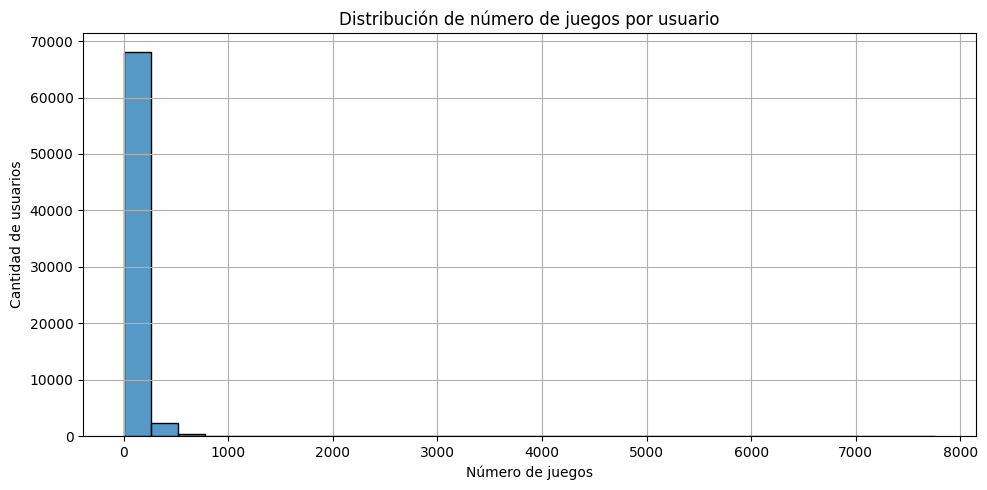


🎯 Top 10 juegos más jugados:
item_name
Dota 2 Test                         49136
Counter-Strike: Global Offensive    43331
Garry's Mod                         42849
Unturned                            38278
Left 4 Dead 2                       36661
Left 4 Dead 2 Beta                  36661
Terraria                            28934
Warframe                            25516
Portal 2                            24206
Counter-Strike: Source              23952
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Juegos únicos y usuarios únicos
n_usuarios = df_user_item['user_id'].nunique()
n_juegos = df_user_item['item_id'].nunique()
n_interacciones = len(df_user_item)

print(f"👥 Usuarios únicos: {n_usuarios}")
print(f"🎮 Juegos únicos: {n_juegos}")
print(f"🧾 Total interacciones usuario-juego: {n_interacciones}")

# Juegos por usuario
juegos_por_usuario = df_user_item.groupby('user_id')['item_id'].count()

# Histograma
plt.figure(figsize=(10, 5))
sns.histplot(juegos_por_usuario, bins=30, kde=False)
plt.title('Distribución de número de juegos por usuario')
plt.xlabel('Número de juegos')
plt.ylabel('Cantidad de usuarios')
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 10 juegos más frecuentes
top_juegos = df_user_item['item_name'].value_counts().head(10)
print("\n🎯 Top 10 juegos más jugados:")
print(top_juegos)


In [6]:
from scipy.sparse import csr_matrix

# Creamos la matriz binaria usuario x juego si no la tienes aún
df_user_item['valor'] = 1

matriz_binaria = df_user_item.pivot_table(
    index='user_id',
    columns='item_id',
    values='valor',
    fill_value=0
)

print("✅ Matriz usuario x juego creada con shape:", matriz_binaria.shape)

# Creamos matriz dispersa para PCA/KMeans
matriz_sparse = csr_matrix(matriz_binaria.values)


✅ Matriz usuario x juego creada con shape: (70912, 10978)


In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# Reducimos dimensionalidad con PCA a 50 componentes (ajustable)
pca = PCA(n_components=50, random_state=42)
matriz_reducida = pca.fit_transform(matriz_sparse.toarray())

# Clustering con KMeans (probamos con 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(matriz_reducida)

# Guardamos los clusters en un DataFrame
df_clusters = pd.DataFrame({'user_id': matriz_binaria.index, 'cluster': clusters})

print("✅ Clustering completado. Distribución de usuarios por cluster:")
print(df_clusters['cluster'].value_counts())


✅ Clustering completado. Distribución de usuarios por cluster:
cluster
1    38005
0    16370
3    13205
2     3226
4      106
Name: count, dtype: int64


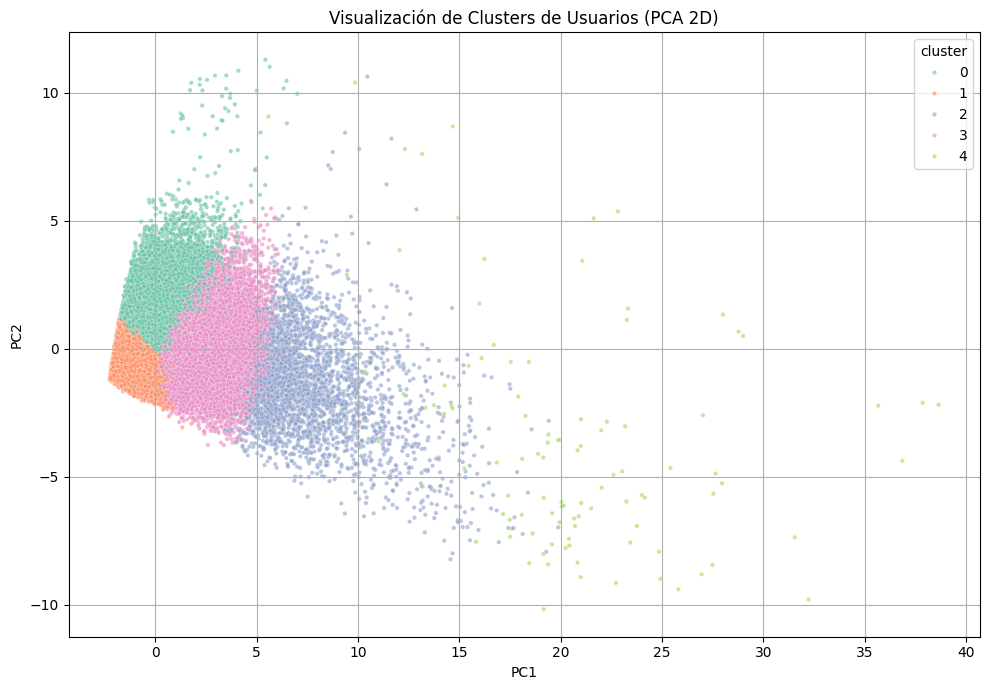

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducimos a 2 dimensiones para visualizar
pca_vis = PCA(n_components=2, random_state=42)
coords_2d = pca_vis.fit_transform(matriz_sparse.toarray())

# Añadimos coordenadas y clusters a un DataFrame
df_vis = pd.DataFrame(coords_2d, columns=['PC1', 'PC2'])
df_vis['cluster'] = clusters

# Gráfico
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='cluster', palette='Set2', s=10, alpha=0.6)
plt.title('Visualización de Clusters de Usuarios (PCA 2D)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Unimos el cluster a cada usuario en el dataset original
df_user_item_clusters = df_user_item.merge(df_clusters, on='user_id')

# Agrupamos por cluster y item_name
juegos_por_cluster = (
    df_user_item_clusters.groupby(['cluster', 'item_name'])
    .size()
    .reset_index(name='count')
)

# Obtenemos el top 10 juegos por cada cluster
top_juegos_por_cluster = (
    juegos_por_cluster
    .sort_values(['cluster', 'count'], ascending=[True, False])
    .groupby('cluster')
    .head(10)
)

# Mostramos resultados
for c in sorted(top_juegos_por_cluster['cluster'].unique()):
    print(f"\n🎯 Top juegos del cluster {c}:")
    juegos = top_juegos_por_cluster[top_juegos_por_cluster['cluster'] == c]
    print(juegos[['item_name', 'count']].to_string(index=False))



🎯 Top juegos del cluster 0:
                       item_name  count
                        Unturned  15126
                     Garry's Mod  14123
Counter-Strike: Global Offensive  13689
                     Dota 2 Test  13302
                        Warframe  11109
                   Left 4 Dead 2  10713
              Left 4 Dead 2 Beta  10713
                       Robocraft  10444
               Heroes & Generals   9620
                        Terraria   9307

🎯 Top juegos del cluster 1:
                       item_name  count
                     Dota 2 Test  22111
Counter-Strike: Global Offensive  15721
                     Garry's Mod  14627
                        Unturned  13642
                   Left 4 Dead 2  11604
              Left 4 Dead 2 Beta  11604
                        Terraria   7504
                        Warframe   7009
          Counter-Strike: Source   7005
                        Portal 2   6309

🎯 Top juegos del cluster 2:
                       item_name 

In [10]:
# Dataset final: user_id, item_id, item_name, cluster
df_user_item_clustered = df_user_item.merge(df_clusters, on='user_id')

# Guardar como CSV
df_user_item_clustered.to_csv('usuarios_items_cluster.csv', index=False)
print("✅ Dataset con clusters guardado como 'usuarios_items_cluster.csv'")


✅ Dataset con clusters guardado como 'usuarios_items_cluster.csv'


In [12]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from collections import defaultdict

# Fusionamos cluster con df_user_item
df_user_item_clustered = df_user_item.merge(df_clusters, on='user_id')

# Creamos diccionario con un DataFrame por cluster
dfs_por_cluster = {
    cluster: df[df['cluster'] == cluster][['user_id', 'item_id']].assign(rating=1)
    for cluster, df in df_user_item_clustered.groupby('cluster')
}

# Mostramos tamaños
for cluster, df in dfs_por_cluster.items():
    print(f"📊 Cluster {cluster}: {df.shape[0]} interacciones")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/alvaro/Escritorio/steam/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/alvaro/Escritorio/steam/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/alvaro/Escritorio/steam/venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).